In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import nltk
import nltk.corpus
import re
import matplotlib.pyplot as plt
import shap
import copy

from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text import FreqDistVisualizer
from sklearn.model_selection import train_test_split
from sklearn import neural_network

from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder

tf.get_logger().setLevel('ERROR')

preprocess_url = "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4"

2023-03-21 11:23:51.930016: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 11:23:52.981307: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-21 11:23:52.981380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-21 11:23:52.981387: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bkapteijns/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/bkapteijns/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/bkapteijns/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
df = pd.read_csv("emails.csv")
df.head()

,text,spam
0,Subject: naturally irresistible your corporate...,1
1,Subject: the stock trading gunslinger fanny i...,1
2,Subject: unbelievable new homes made easy im ...,1
3,Subject: 4 color printing special request add...,1
4,"Subject: do not have money , get software cds ...",1


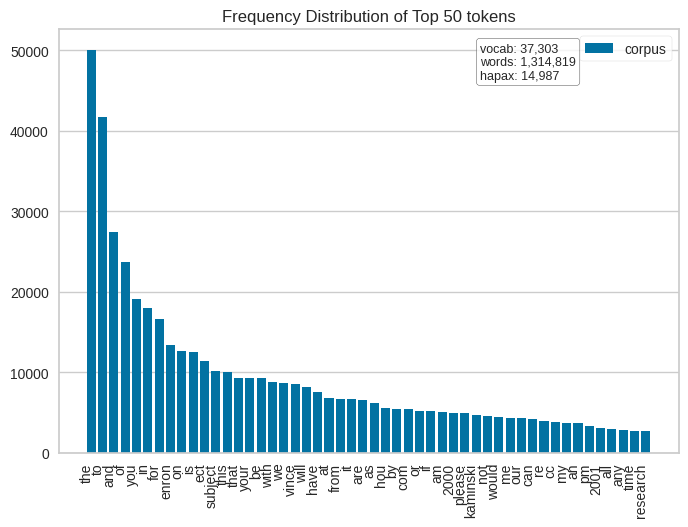

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [4]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(df["text"])
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [5]:
text = df["text"]
labels = df["spam"]

print(text.shape, labels.shape)

(5728,) (5728,)


In [6]:
indices = []
for x in text:
    if (len(x.split(' ')) < 100):
        indices.append(True)
    else:
        indices.append(False)

text = text[indices]
labels = labels[indices]

In [7]:
print(text.shape, labels.shape)

(1158,) (1158,)


In [8]:
print(np.sum(labels == 0), np.sum(labels==1))

744 414


In [9]:
# remove digits, @-mentions, links, stopwords

text = text.str.lower()
text = text.apply(lambda elem: re.sub(r"(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})", "", elem))
text = text.apply(lambda x : nltk.word_tokenize(x))
text = text.apply(lambda x : " ".join([word for word in x if word not in nltk.corpus.stopwords.words()]))

text.shape

(1158,)

In [10]:
# import pickle
# with open("text.pkl", "wb") as f:
#   pickle.dump(text, f)
# with open("labels.pkl", "wb") as f:
#   pickle.dump(labels, f)

In [11]:
# import pickle
# with open("text.pkl", "rb") as f:
#   text = pickle.load(f)
# with open("labels.pkl", "rb") as f:
#   labels = pickle.load(f)

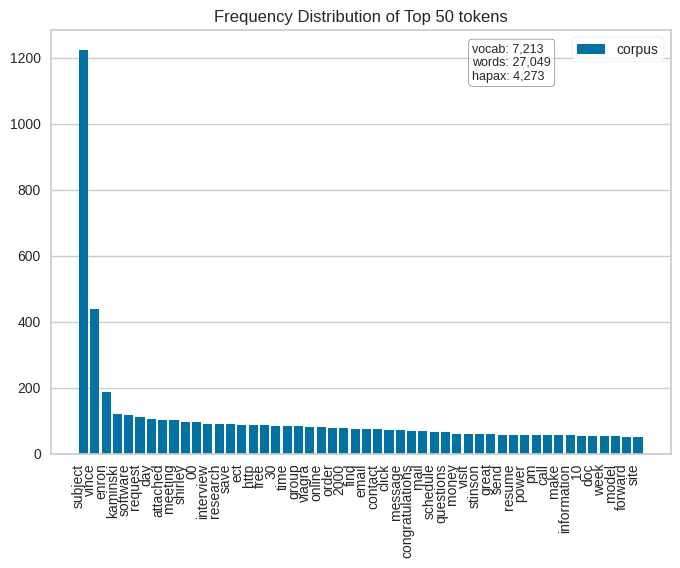

<Axes: title={'center': 'Frequency Distribution of Top 50 tokens'}>

In [12]:
%matplotlib inline
vectorizer = CountVectorizer()
docs       = vectorizer.fit_transform(text)
features   = vectorizer.get_feature_names_out()
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(docs)
visualizer.show()

In [13]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
print(text)

1       subject : stock trading gunslinger fanny merri...
2       subject : unbelievable homes made easy wanting...
4       subject : money , software cds ! software comp...
16      subject : software guaranteed 100 % legal . - ...
18      subject : security alert - confirm national cr...
                              ...                        
5689    subject : ' trip stanford shirley , office 10 ...
5694    subject : ljm model ryan : updated spreadsheet...
5704    subject : storage model security stinson , add...
5709    subject : agenda larry thorne ' presentation m...
5710    subject : raptors recent version spreadsheet a...
Name: text, Length: 1158, dtype: object


In [15]:
lengths = []

X = np.array(text)
for i in range(len(text)):
  X[i] = tokenizer.tokenize(X[i])
  X[i] = tokenizer.convert_tokens_to_ids(X[i])

for i in range(len(X)):
  lengths.append(len(X[i]))

In [16]:
lengths = np.array(lengths)
X = np.array(X)

print(np.sum((lengths < 64) & (labels == 1)), np.mean((lengths < 64) & (labels == 1)))
print(np.sum((lengths < 64) & (labels == 0)), np.mean((lengths < 64) & (labels == 0)))

326 0.2815198618307427
669 0.5777202072538861


In [17]:
X_positive = X[(lengths < 64) & (labels == 1)].tolist()
X_negative = X[(lengths < 64) & (labels == 0)].tolist()
X = X_positive[:300] + X_negative[:300]

y_positive = labels[(lengths < 64) & (labels == 1)].tolist()
y_negative = labels[(lengths < 64) & (labels == 0)].tolist()
y = y_positive[:300] + y_negative[:300]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y), train_size=500, shuffle=True)

X_test = X_test[:50]
y_test = y_test[:50]

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [19]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(500,) (500,) (50,) (50,)


In [20]:
import torch

model.config.max_position_embeddings = 64
max_length = model.config.max_position_embeddings

X_train_padded = []
X_test_padded = []

for i in range(len(X_train)):
  X_train_padded.append(X_train[i] + [0] * (max_length - len(X_train[i])))
for i in range(len(X_test)):
  X_test_padded.append(X_test[i] + [0] * (max_length - len(X_test[i])))

X_train_padded = torch.from_numpy(np.array(X_train_padded))
X_test_padded = torch.from_numpy(np.array(X_test_padded))

In [21]:
bert_train_output = model(X_train_padded)
print(bert_train_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1273, -0.2791,  0.4336,  ..., -0.7773,  0.1330, -0.1502],
         [-0.1988, -0.0046,  1.0970,  ..., -0.5538,  0.5648,  0.2732],
         [-0.4403,  0.2870,  0.9980,  ..., -0.5565,  0.5294,  0.4885],
         ...,
         [ 0.3052, -0.0343,  0.4222,  ..., -0.7495,  0.0408,  0.1377],
         [ 0.6769, -0.1054,  0.8148,  ..., -0.7338,  0.1689, -0.0217],
         [ 0.0780, -0.1864,  0.6028,  ..., -0.7914,  0.1786,  0.2559]],

        [[-0.0298, -0.0293, -0.0072,  ..., -0.6288,  0.6904, -0.1285],
         [ 0.1274,  0.1757,  0.8595,  ..., -0.2197,  0.3429,  0.0878],
         [ 0.6044,  0.2348,  1.2138,  ..., -0.2132,  0.4610,  0.3024],
         ...,
         [-0.0176,  0.0095,  0.2275,  ..., -0.9323,  0.7594, -0.3425],
         [-0.0277, -0.0050,  0.2132,  ..., -0.9488,  0.7980, -0.4046],
         [-0.0641, -0.0774,  0.1488,  ..., -0.9393,  0.7867, -0.4465]],

        [[-0.1796, -0.2824, -0.1233,  ..., -0.5226,  

In [22]:
bert_train_output = bert_train_output[1].detach().numpy().copy()
bert_train_output = bert_train_output.reshape(X_train.shape[0], 768)

In [23]:
bert_test_output = model(X_test_padded)
print(bert_test_output)

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-6.0917e-02, -1.6852e-01,  3.4947e-01,  ..., -3.6606e-01,
           4.3909e-01, -1.8298e-01],
         [-9.8840e-02, -3.1792e-01,  8.0259e-01,  ..., -2.8272e-01,
           4.3786e-01,  1.3833e-01],
         [ 1.5628e-01, -3.3871e-01,  8.9999e-01,  ..., -3.3147e-01,
           1.6657e-01, -2.8977e-01],
         ...,
         [-4.1948e-02, -2.7011e-01,  5.6460e-01,  ..., -6.3028e-01,
           7.4295e-01, -6.4607e-01],
         [-5.7515e-02, -3.2599e-01,  5.5913e-01,  ..., -6.6531e-01,
           8.0279e-01, -7.2208e-01],
         [-4.5873e-02, -3.5834e-01,  4.5506e-01,  ..., -7.4662e-01,
           8.5891e-01, -7.6387e-01]],

        [[ 3.1351e-02,  2.0367e-02, -2.7965e-01,  ..., -4.4535e-01,
           5.3616e-01, -4.3257e-02],
         [ 1.5950e-01,  3.4889e-01, -2.5270e-02,  ..., -2.4879e-01,
           1.3957e-01,  3.9678e-01],
         [ 1.6344e-01,  4.3480e-01, -4.9957e-02,  ..., -3.4393e-01,
           8.

In [24]:
bert_test_output = bert_test_output[1].detach().numpy().copy()
bert_test_output = bert_test_output.reshape(X_test.shape[0], 768)

In [25]:
clf = neural_network.MLPClassifier()
clf.fit(bert_train_output, y_train)

MLPClassifier()

In [26]:
print("Train accuracy:", np.mean(clf.predict(bert_train_output) == y_train))
print("Test accuracy:", np.mean(clf.predict(bert_test_output) == y_test))

Train accuracy: 0.91
Test accuracy: 0.9


In [27]:
print(np.unique(y_test))

[0 1]


In [28]:
np.mean(y_test==0)

0.58

In [29]:
shap.initjs()

In [30]:
to_explain = np.array(X_test_padded)[:20]
to_explain.shape

(20, 64)

In [31]:
def prediction_model(X):
  bert_output = model(torch.from_numpy(np.array(X)).to(torch.int64))
  sequence_output = bert_output[1].detach().numpy()
  return clf.predict(sequence_output.reshape(X.shape[0], 768))

In [32]:
permutation_values = []
permutation_explainer = shap.explainers.Permutation(prediction_model, np.array(to_explain))
for i in range(len(to_explain)):
  permutation_values.append(permutation_explainer(np.array([to_explain[i]])))

Permutation explainer: 2it [03:29, 209.75s/it]                                                                                        
Permutation explainer: 2it [02:35, 155.88s/it]                                                                                        
Permutation explainer: 2it [02:29, 149.99s/it]                                                                                        
Permutation explainer: 2it [02:18, 138.41s/it]                                                                                        
Permutation explainer: 2it [03:22, 202.12s/it]                                                                                        
Permutation explainer: 2it [02:44, 164.85s/it]                                                                                        
Permutation explainer: 2it [02:48, 168.98s/it]                                                                                        
Permutation explainer: 2it [02:17, 137.43s/it]         

In [33]:
perm_vals = {"values": [], "base_values": [], "data": []}
for pv in permutation_values:
    perm_vals["values"].append(pv.values[0])
    perm_vals["base_values"].append(pv.base_values[0])
    perm_vals["data"].append(pv.data[0])

Sentence: subject : ready ? ! via ##gra # 1 struggle men ##s ' erect ##ile dysfunction . jokes sai ##s , st ##ron ##q en ##ou ##q ##h , made woman ; - ) order ##in ##q via ##q ##ra online con ##vin ##ient , fast secure ! millions daily save privacy money order . . . ; Prediction: [1] ; True value: 1


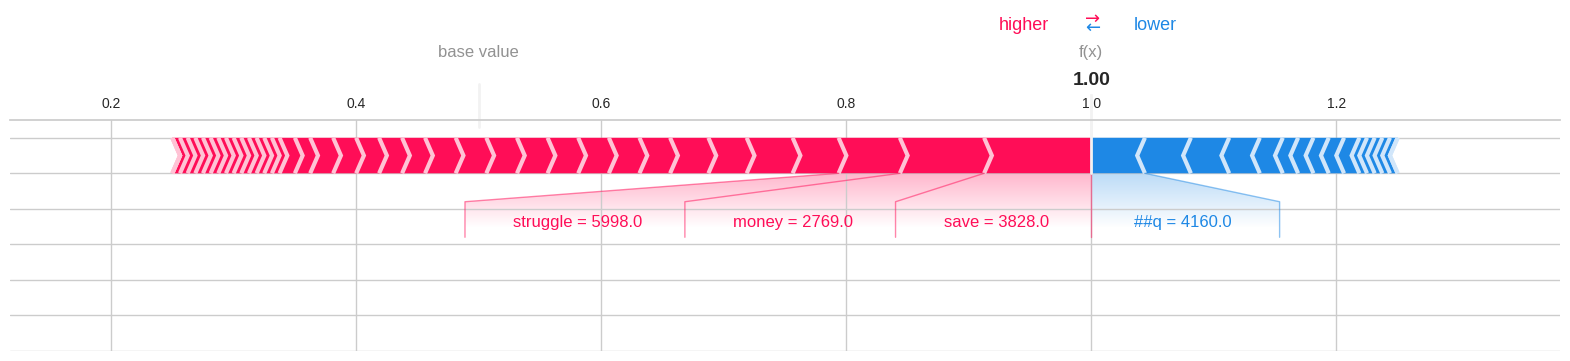

Sentence: subject : largest membership sites free porn free free password : 18 asian huge tits xx ##x free amateur hot ##ties free hot ##ties free kin ##ky free farm sl ##uts free ' famous adults dil ##igen ##t ; Prediction: [1] ; True value: 1


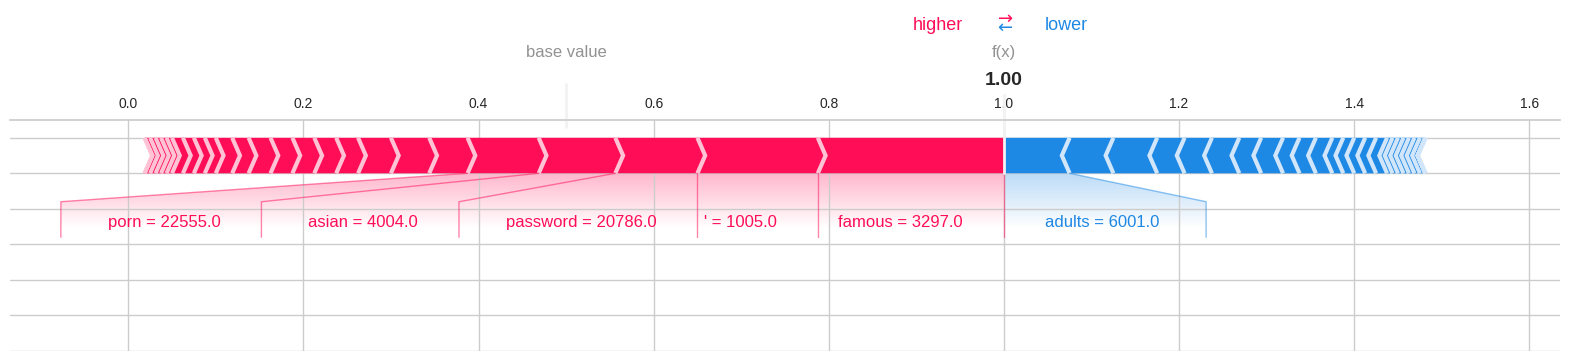

Sentence: subject : specific medication ? ! healthy living everyday life . rarely con ##fide . words en ##light ##en soul precious jewels . ignore awful times , concentrate . free imagination , bound reason . ; Prediction: [1] ; True value: 1


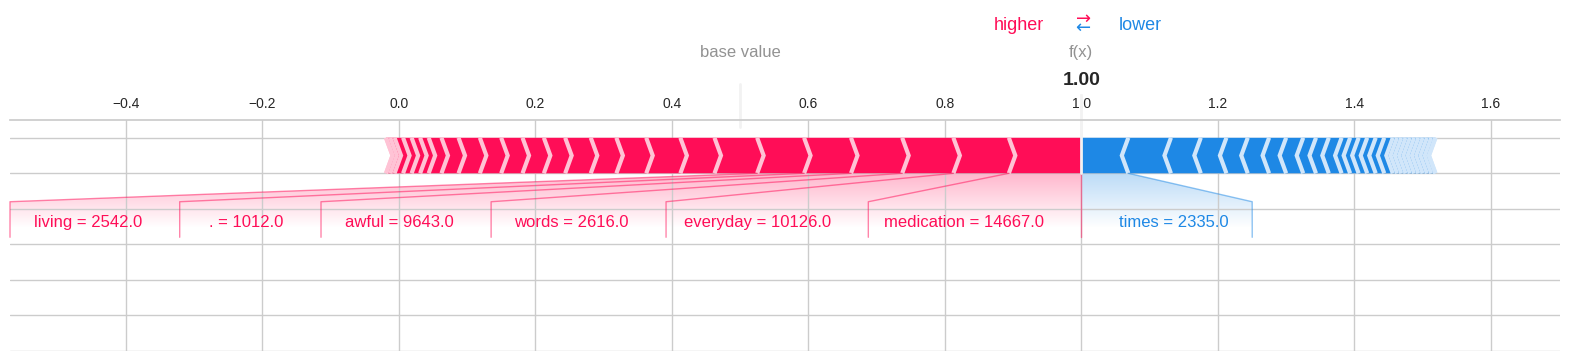

Sentence: subject : : congratulations back . . . . . great job ; Prediction: [0] ; True value: 0


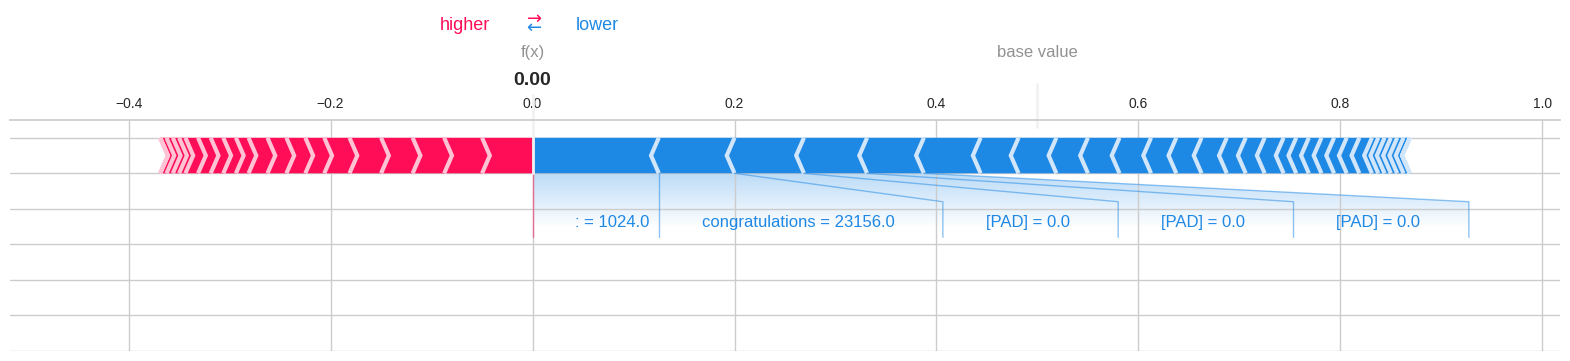

Sentence: subject : rotation lean ##dro ` ` roy ` ` ib ##asco celeste : plans works rotate roy ib ##asco research group henry ar ##ora ' group . vanessa carr ##anza handling chu ##rn request . rotation date , desk 15 g ##wyn ko ##ep ##ke . probably , case . shirley 3 - 52 ##90 ; Prediction: [1] ; True value: 0


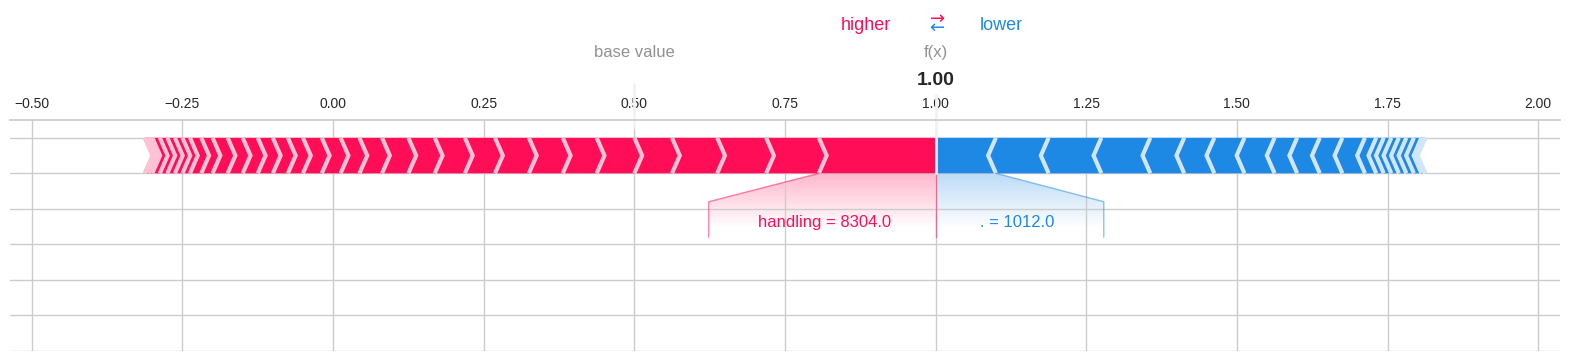

Sentence: subject : meeting mark : enjoyed meeting tu ##sed ##ay forward calling week . idea present senior en ##ron executives including ko ##eni ##g , , jeff skill ##ing . discussed bit vince kam ##inski thursday expressed strong interest attending meeting . , ; Prediction: [0] ; True value: 0


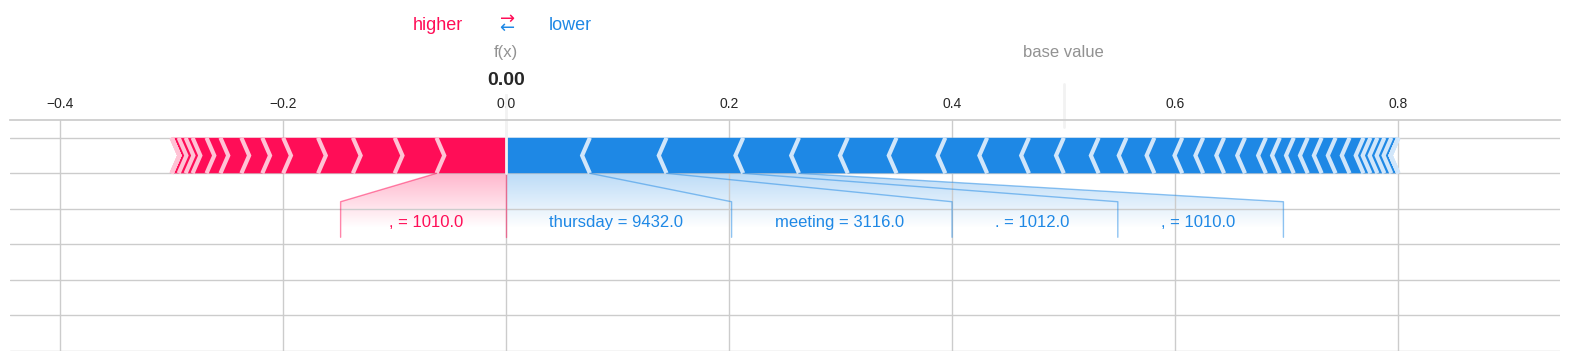

Sentence: subject : ultimate pc security surveillance . * message compliance email bill hr 1910 . bill hr 1910 passed 106 congress 24 , 1999 . section hr 1910 . wish removed mail ##ing list , click . removal requests handled electronically 24 hours effect . ; Prediction: [1] ; True value: 1


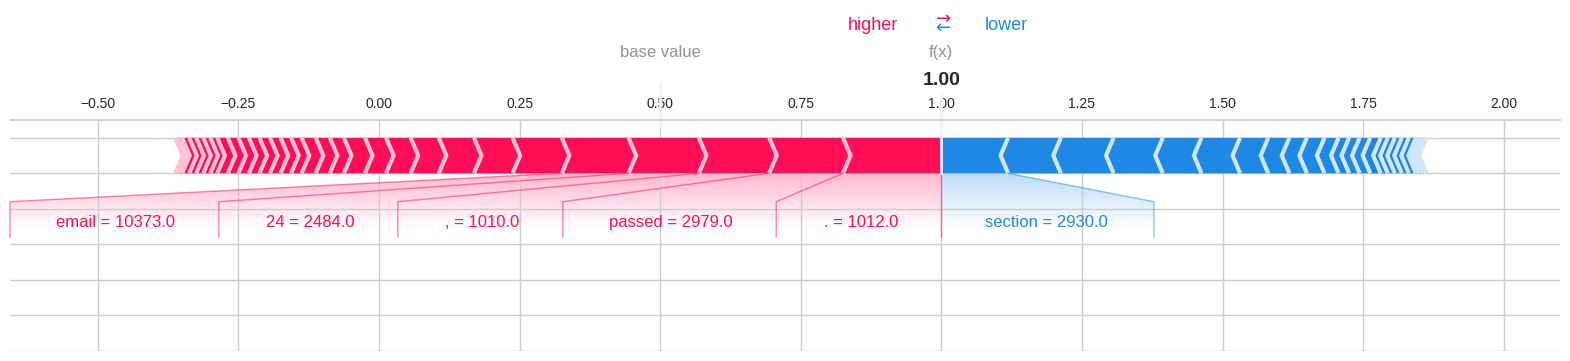

Sentence: subject : save money o ##em software ! software pc ? visit site , . . . , hi ##en ; Prediction: [1] ; True value: 1


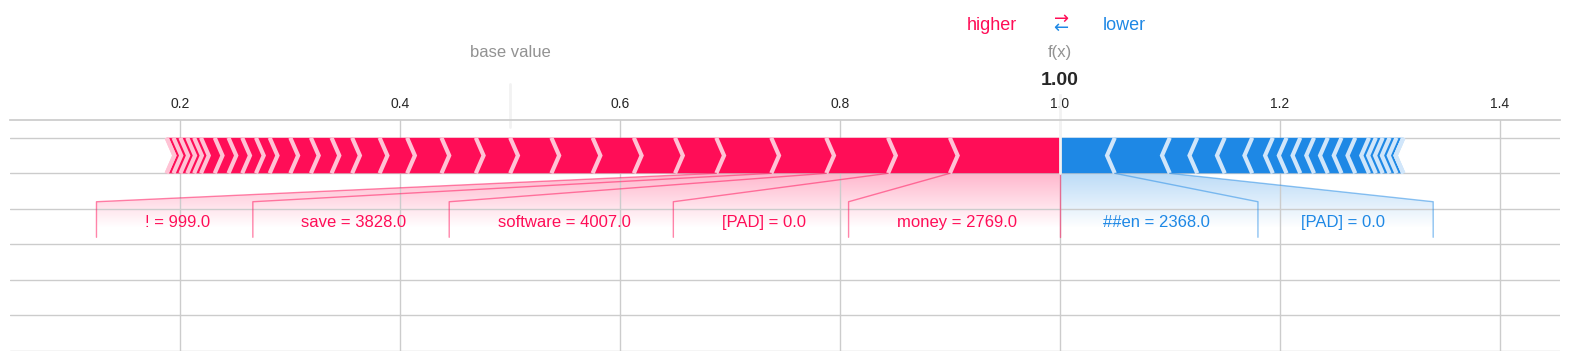

Sentence: subject : start shopping cost ##co today compliment ##ary gold membership . start shopping cost ##co today free gold membership . free gold membership upgrade extend existing membership . ( ) ip ##ml ##gb ##it ; Prediction: [1] ; True value: 1


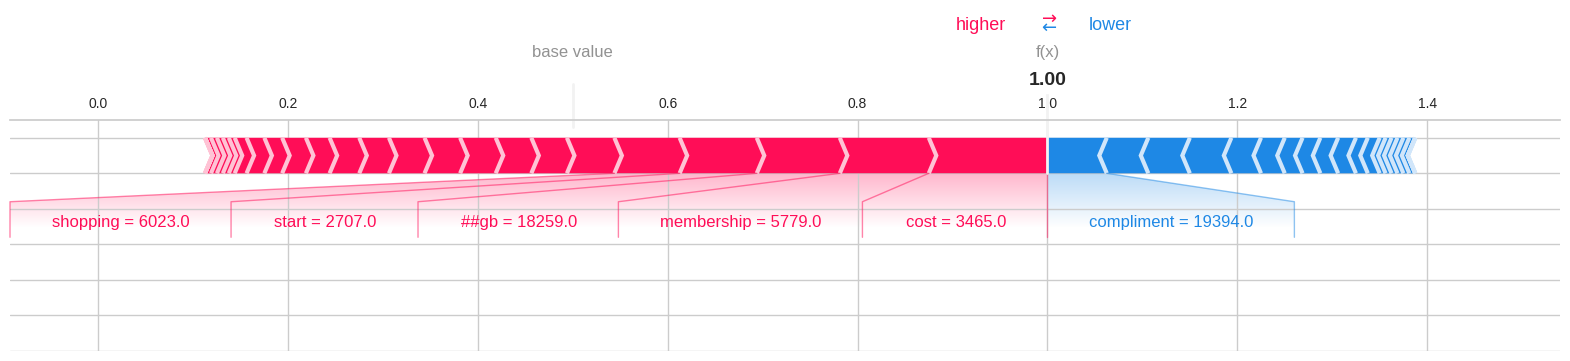

Sentence: subject : - home source health information remember magnificent sex ? wish repeat ? advantage offer ! rich ##ness rich ##ness soul . words actions assassins ideal ##ism . general principles based exceptional cases . ; Prediction: [0] ; True value: 1


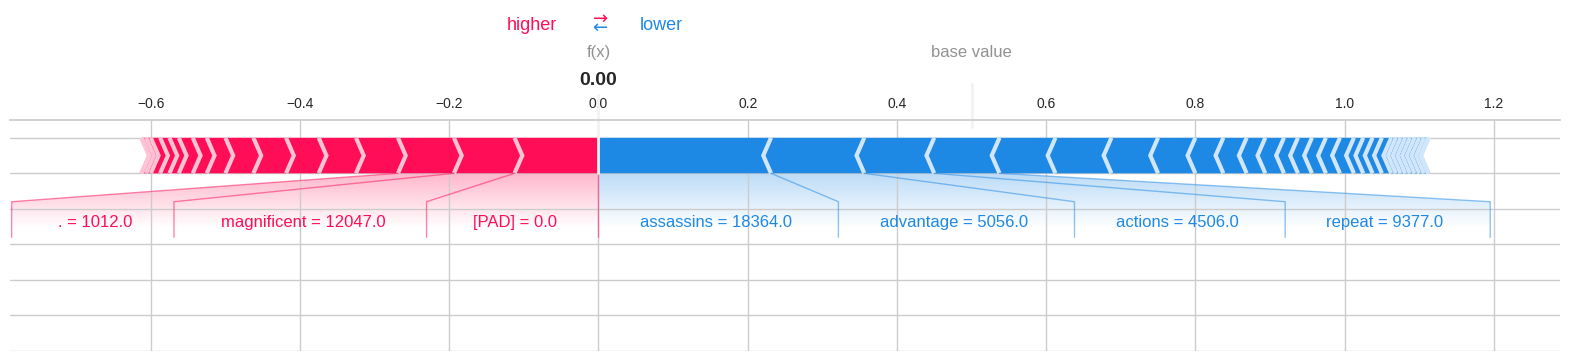

Sentence: subject : ' satisfy f ##gt ##pr ##il endowed 7 - 8 ` ` hammer simply equipped 5 - 6 ` ` hammer . have ##more job fall short . ' totally up ##to . methods guaranteed increase size 1 - 3 ` ` enter ; Prediction: [0] ; True value: 1


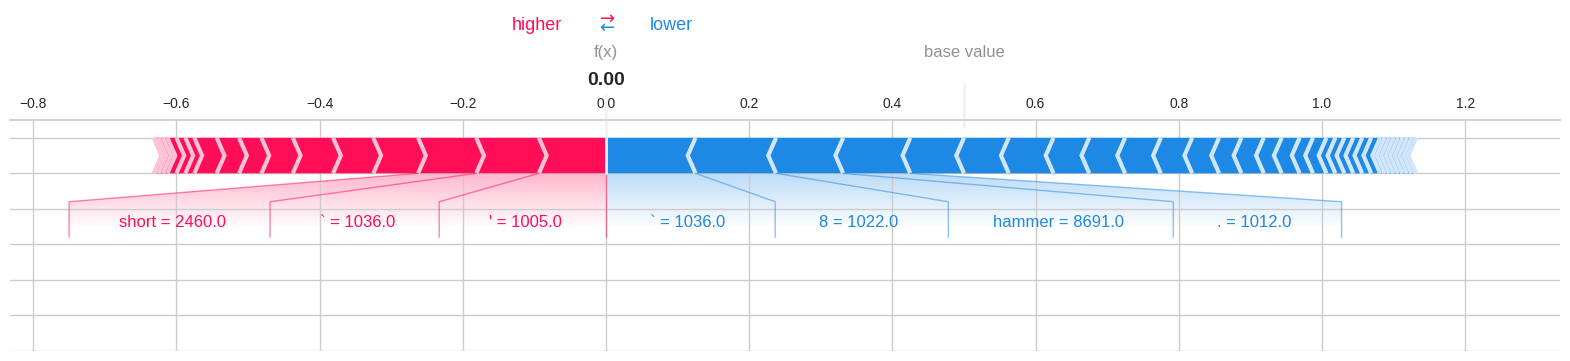

Sentence: subject : book papers , ! fed ##ex dropped week , ' happily reading away . ! keith bag ##ger ##ly ; Prediction: [0] ; True value: 0


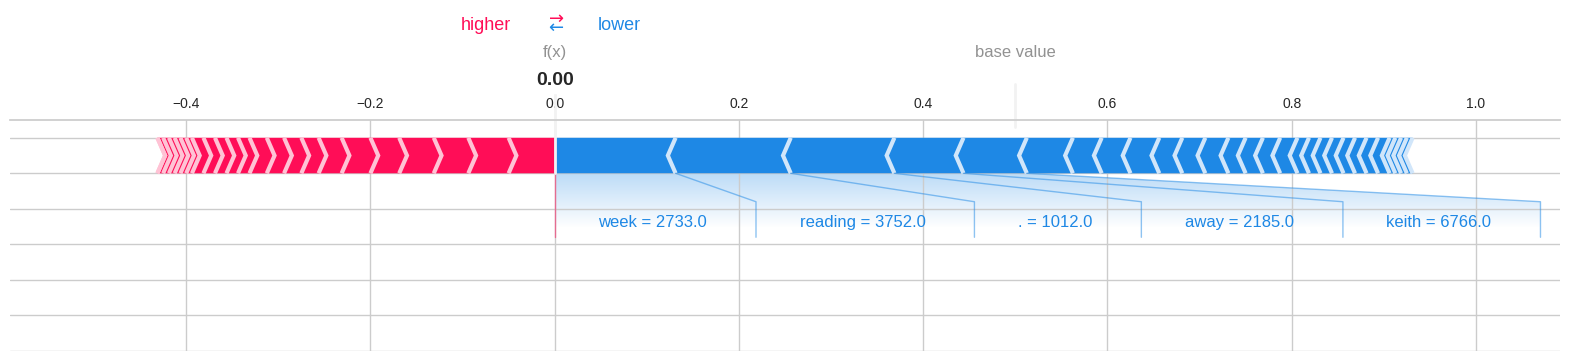

Sentence: subject : warning system greg , follow . talking jay webb today data en ##ron online system develop early warning system automated crude trading . , catch . left red faced . vince ; Prediction: [0] ; True value: 0


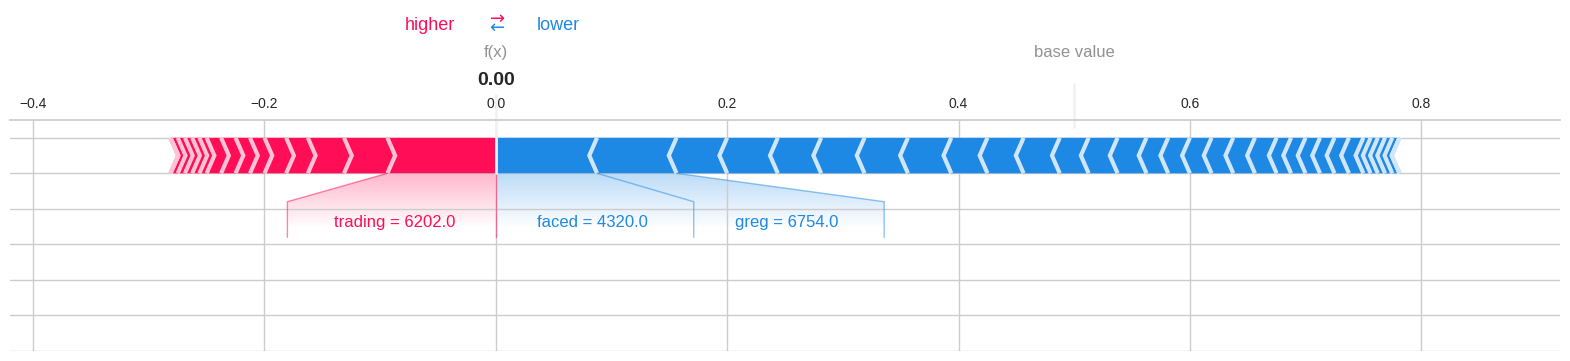

Sentence: subject : : book review great job vince . knocking book . fact consultants make lot money ' res ##elling ' stuff book ! hand & version . 133 article - - work nuclear engineer bomb ! ravi . ; Prediction: [0] ; True value: 0


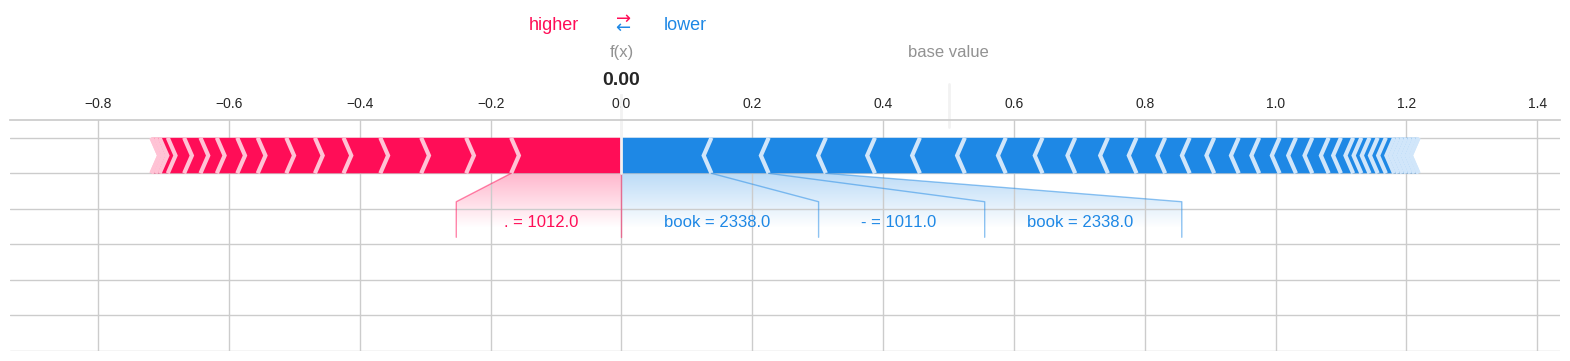

Sentence: subject : mark , , check web - site . com ##mis ##ison study guy . vince ; Prediction: [0] ; True value: 0


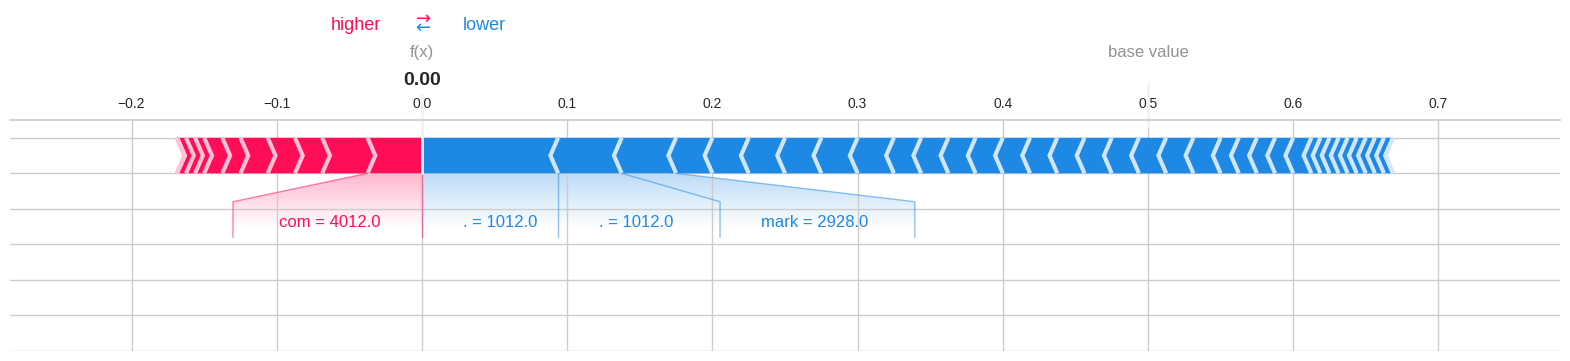

Sentence: subject : mgm ##t 65 ##6 enclosed find final grade roster ##s mgm ##t 65 ##6 . grades due office friday , 4 . remember university deadline graduating students . ! - pam ( 71 ##3 - 34 ##8 - 62 ##23 ) - 65 ##6 . doc ; Prediction: [0] ; True value: 0


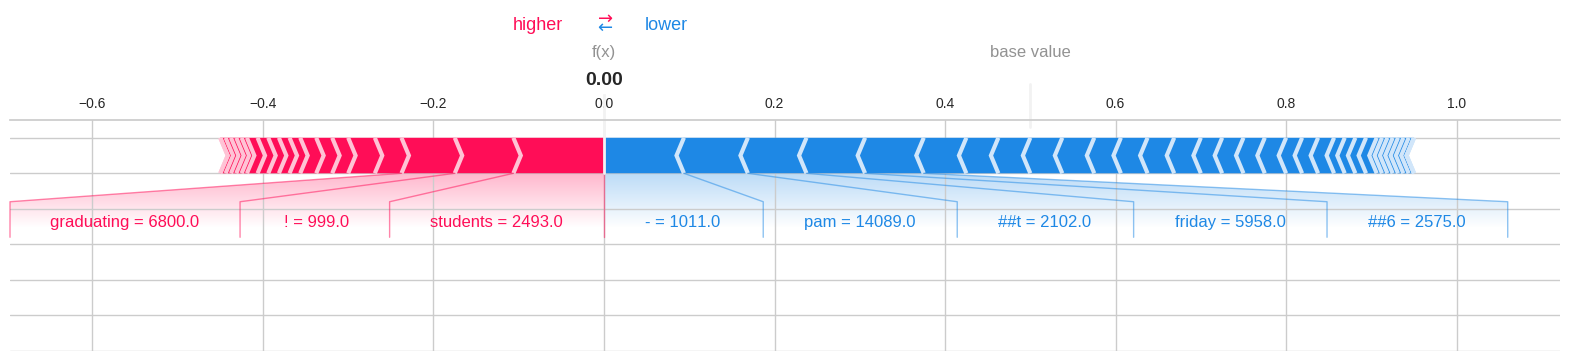

Sentence: subject : 10 minutes sex , lasts 24 - 36 hours legal , prescription medications essential guidance licensed medical stone lu ##rks politician . experience mistakes . music , life mistake . ; Prediction: [1] ; True value: 1


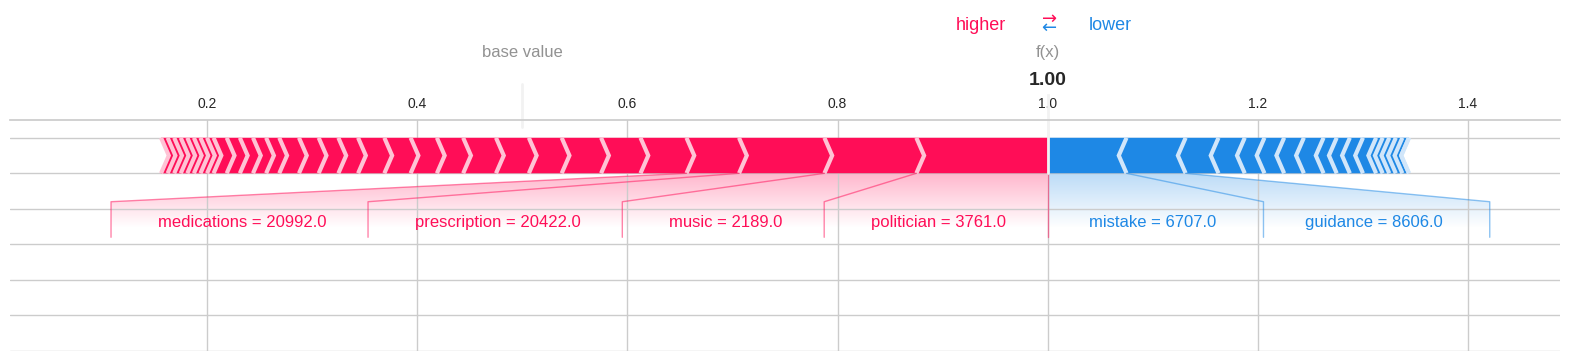

Sentence: subject : customer prof ##iling meeting - amendment bob shu ##lts scheduled atlanta , 17 march res ##ched ##ule ` ` customer prof ##iling meeting ` ` , tuesday , march 24 st 1 : 30 p . . , location announced . unable attend . lydia 3 - 99 ##75 ; Prediction: [0] ; True value: 0


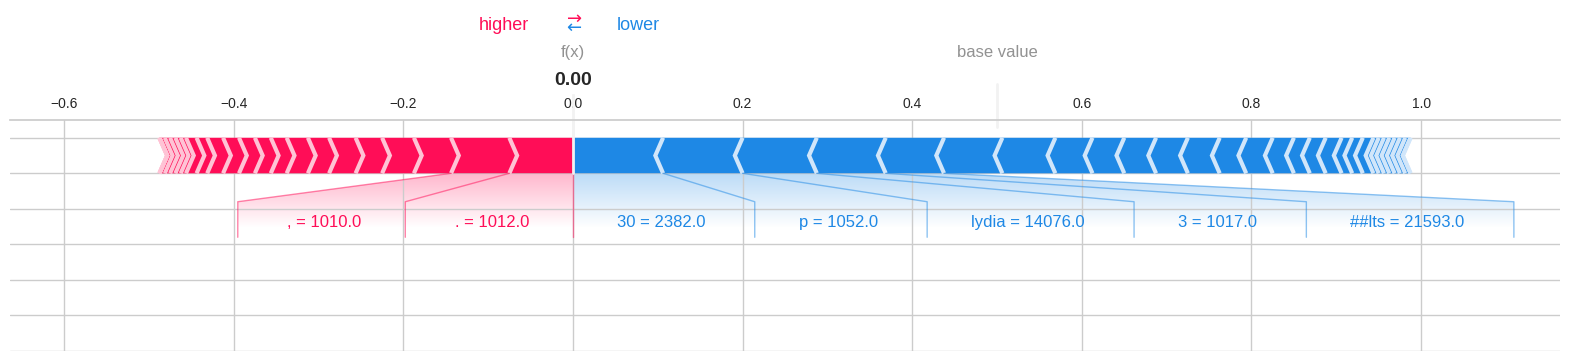

Sentence: subject : - home source health information medicine , different price ! bed mad . stay fight . justice ordering society centered . use ##net te ##tri ##s remember read . weird , weird turn pro . ; Prediction: [1] ; True value: 1


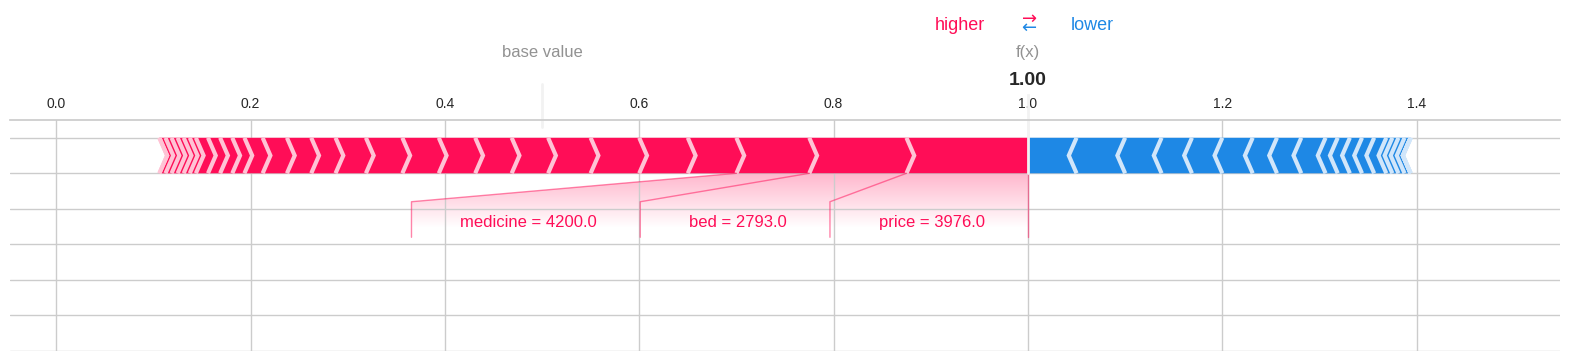

Sentence: subject : save 40 % popular software bundles ! software taking bite budget ? o ##em ! live free ; death worst evil ##s . living joy . ; Prediction: [1] ; True value: 1


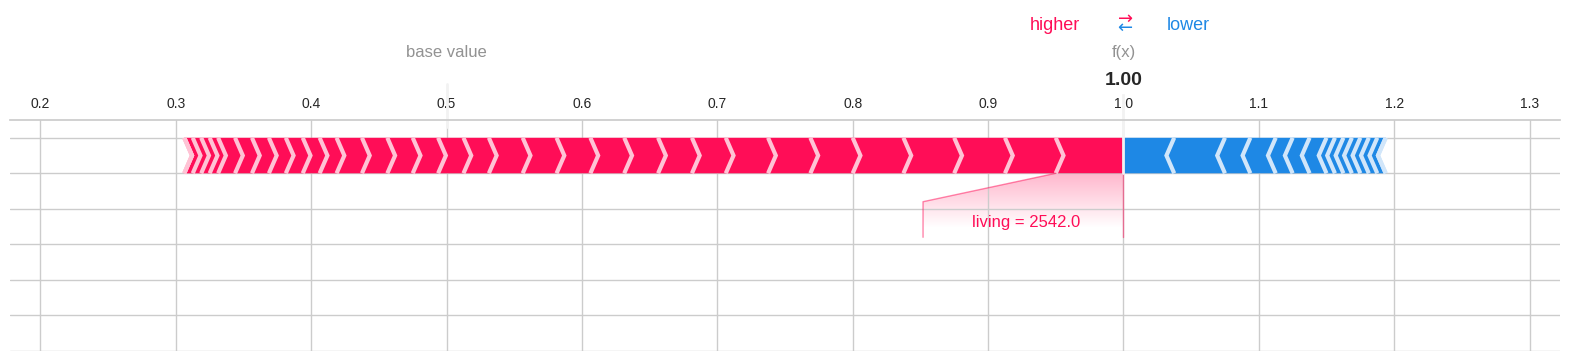

In [34]:
for i in range(len(to_explain)):
  print("Sentence:", " ".join(tokenizer.convert_ids_to_tokens(to_explain[i])).replace(" [PAD]", "") ,"; Prediction:", prediction_model(np.array([to_explain[i]])), "; True value:", y_test[i])
  shap.plots.force(perm_vals["base_values"][i], perm_vals["values"][i], perm_vals["data"][i], feature_names=tokenizer.convert_ids_to_tokens(perm_vals["data"][i]), matplotlib=True)

In [35]:
import copy
heatmaps = np.array(copy.copy(perm_vals["values"]))
heatmaps += perm_vals["base_values"][0]/64
for i in range(len(heatmaps)):
  print(np.sum(heatmaps[i]))

1.0
1.0
1.0
2.7755575615628914e-17
1.0
0.0
1.0
1.0
1.0
0.0
1.3877787807814457e-17
4.163336342344337e-17
-6.938893903907228e-18
0.0
2.0816681711721685e-17
1.3877787807814457e-17
1.0
4.163336342344337e-17
1.0
1.0


Prediction: spam


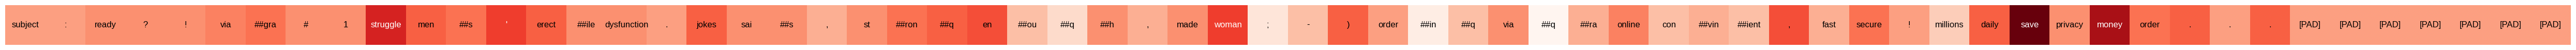

Prediction: spam


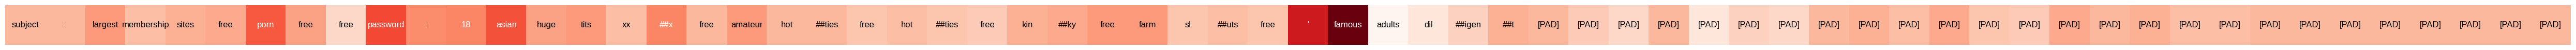

Prediction: spam


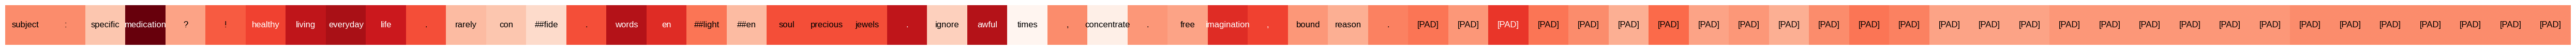

Prediction: legit


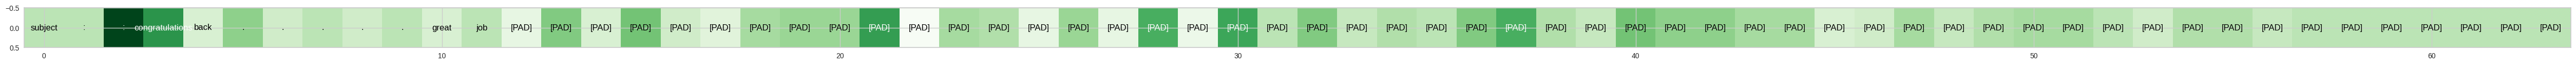

Prediction: spam


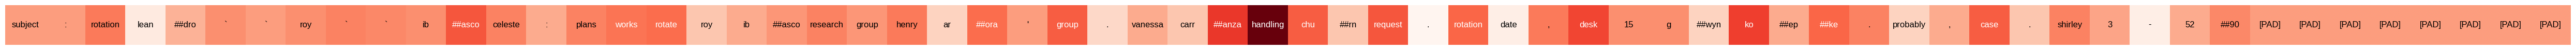

Prediction: legit


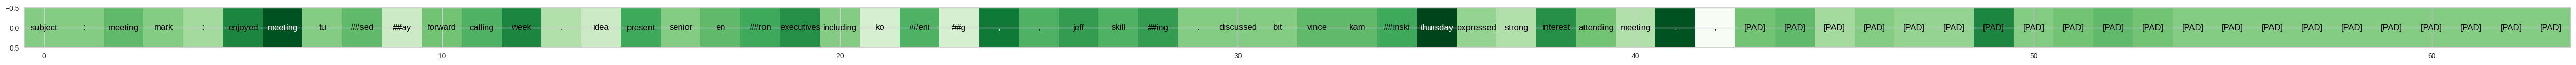

Prediction: spam


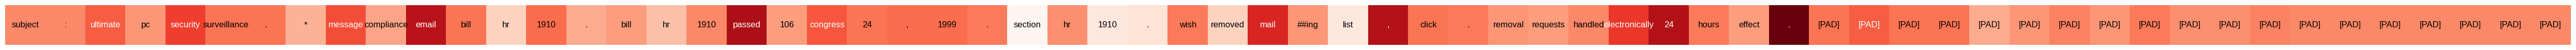

Prediction: spam


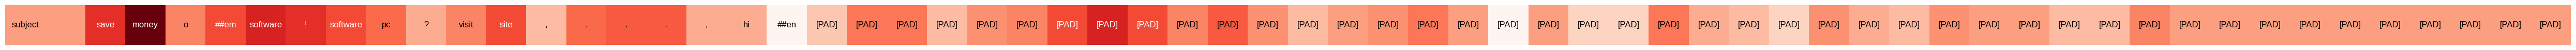

Prediction: spam


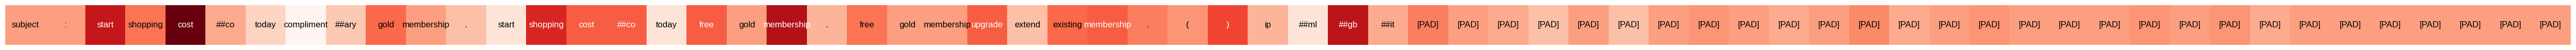

Prediction: legit


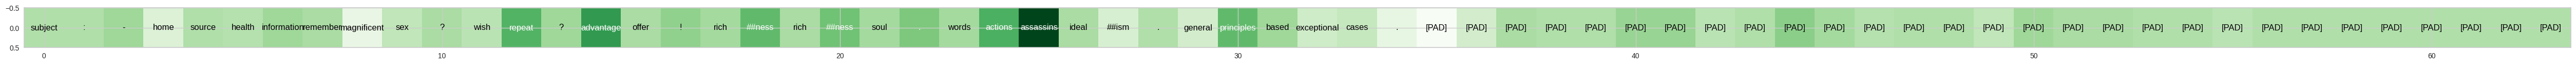

Prediction: legit


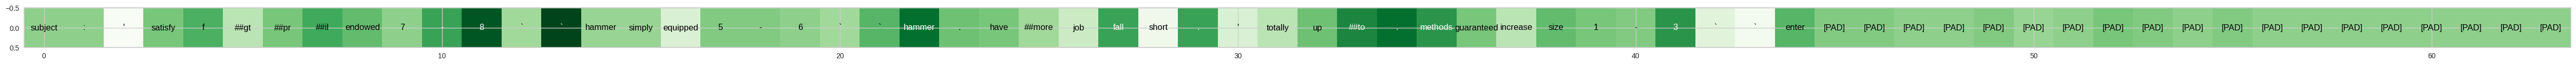

Prediction: legit


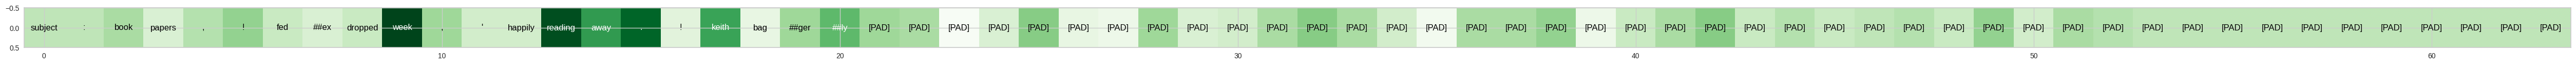

Prediction: legit


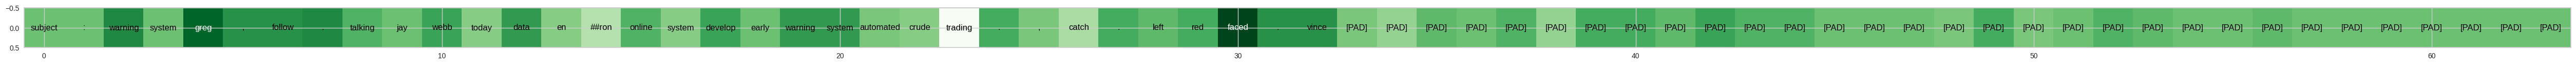

Prediction: legit


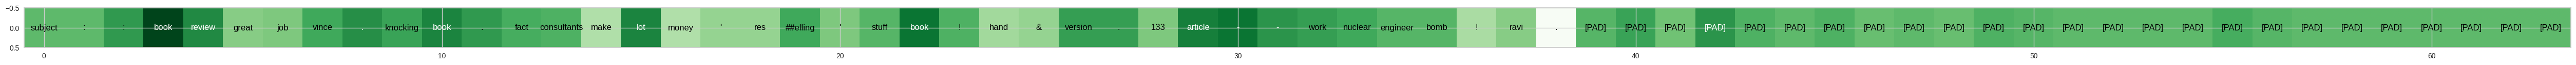

Prediction: legit


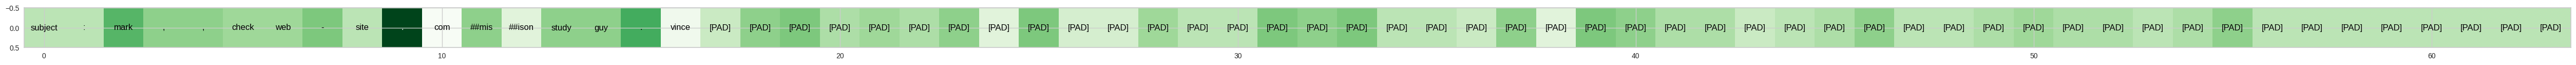

Prediction: legit


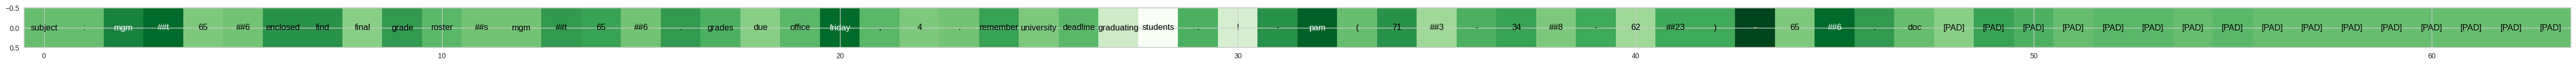

Prediction: spam


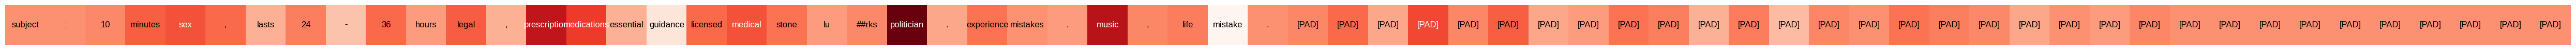

Prediction: legit


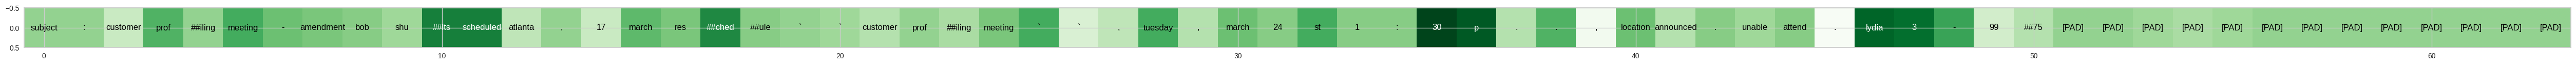

Prediction: spam


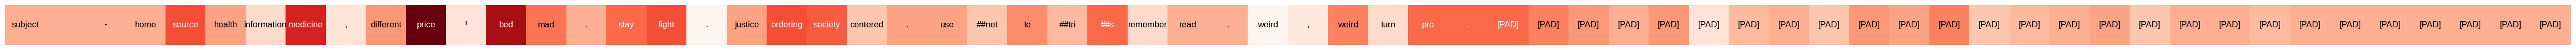

Prediction: spam


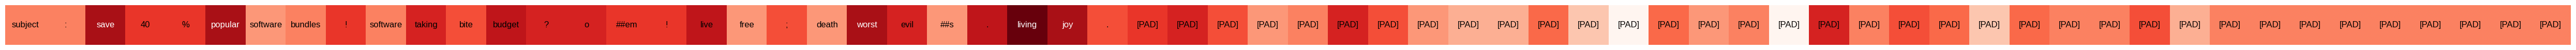

In [36]:
for x in range(len(to_explain)):
  fig, ax = plt.subplots(figsize=(len(to_explain[x]), 1))
  if prediction_model(np.array([to_explain[x]]))[0] == 0:
    print("Prediction: legit")
    ax.imshow([-heatmaps[x]], cmap="Greens", aspect="auto")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] < -0.04 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))
  else:
    print("Prediction: spam")
    ax.imshow([heatmaps[x]], cmap="Reds", aspect="auto")
    ax.axis("off")
    for i, id in enumerate(to_explain[x]):
      color = plt.cm.Blues(heatmaps[x][i])
      ax.text(i, 0, tokenizer.convert_ids_to_tokens([id])[0], ha="center", va="center", fontsize="12", color="white" if heatmaps[x][i] > 0.04 else "black")#color="white" if heatmaps[x][i] > 0.5 else "black", bbox=dict(facecolor=color, edgecolor=color, pad=1))


  plt.show()

In [37]:
# import dill
# filename = 'globalsave.pkl'
# # to save the session:
# #dill.dump_session(filename)

# # and to load the session again:
# #dill.load_session(filename)

In [38]:
def ablate(x, i):
  x[i] = 0
  for j in range(i, len(x)-1):
    x[j] = x[j+1]
  x[-1] = 0
  return x
def compute_contrast(X, model, explanation):
  contrast = [0]*len(X)
  for i in range(len(X)):
    old_prediction = model(np.array([X[i]]))
    for j in range(len(X[i])):
      x = ablate(copy.deepcopy(X[i]), j)
      new_prediction = model(np.array([x]))
      if (new_prediction != old_prediction):
        contrast[i] += explanation[i][j]
  return contrast

In [39]:
def compute_distinctiveness(data, train_data, explanation):
  distinctiveness = [0] * len(data)

  frequencies = []
  for x in np.unique(train_data):
    frequencies.append((np.mean(np.array(train_data) == x), x))
  sorted_frequencies = sorted(frequencies)
  word_specialty = {0: 0}
  for i, (f, x) in enumerate(sorted_frequencies):
    word_specialty[x] = 1 - i / len(sorted_frequencies)

  for i in range(len(data)):
    for j in range(len(data[i])):
      try:
        distinctiveness[i] += word_specialty[data[i][j]] * explanation[i][j]
      except:
        distinctiveness[i] += explanation[i][j]

  return distinctiveness

In [40]:
import copy
def compute_fidelity(X, explanation, model):
    fidelity = [0] * len(X)
    samples = 5
    for i in range(len(X)):
        change_ratings = [0]*len(X[i])
        x = 0
        while x < len(X[i]):
            print(x)
            change_rating = 0
            for change in range(samples):
                new_X = copy.deepcopy(X[i])
                new_X[x] = new_X[x] + (100 * change / samples)
                if (model(np.array([X[i]])) == model(np.array([new_X]))):
                    change_rating += 1/samples
            change_ratings[x] = change_rating
            if (X[i][x] == 0):
                x = len(X[i])
            x += 1
            
        for j in range(len(X[i])):
            fidelity[i] += change_ratings[j] * explanation[i][j]
    return fidelity

In [41]:
from nltk.corpus import wordnet as wn
def compute_realism(data, id_to_token, topic, explanation):
  """
  data: the word ids in the shape of #elements x #words
  topic: a wordnet synset
  id_to_token: a function from ids to tokens

  returns an array of length #elements
  """
  metrics = [0] * len(data)
  for i in range(len(data)):
    for j in range(len(data[i])):
      try:
        metrics[i] += explanation[i][j] * topic.wup_similarity(wn.synsets(id_to_token([data[i][j]])[0])[0])
      except:
        pass
  return metrics

In [42]:
def explanation_converter(explanations):
  new_explanations = []
  for i in range(len(explanations)):
    if (np.sum(explanations[i]) > 0):
      new_explanations.append(explanations[i] + (1 - np.sum(explanations[i]))/64)
    else:
      new_explanations.append(-explanations[i] + (1 + np.sum(explanations[i]))/64)
  return new_explanations
standardized_explanations = explanation_converter(perm_vals["values"])

In [43]:
for x in standardized_explanations:
  print(np.sum(x))
print(standardized_explanations)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.9999999999999999
1.0
1.0
1.0
1.0
[array([ 0.0078125,  0.0078125,  0.0140625,  0.0140625,  0.0140625,
        0.0203125,  0.0265625,  0.0140625,  0.0140625,  0.0578125,
        0.0328125,  0.0265625,  0.0453125,  0.0328125,  0.0140625,
        0.0140625,  0.0078125,  0.0328125,  0.0140625,  0.0140625,
        0.0015625,  0.0140625,  0.0265625,  0.0328125,  0.0390625,
       -0.0046875, -0.0171875,  0.0140625,  0.0015625,  0.0140625,
        0.0453125, -0.0234375, -0.0046875,  0.0328125,  0.0078125,
       -0.0296875, -0.0046875,  0.0140625, -0.0359375,  0.0015625,
        0.0203125, -0.0046875,  0.0015625, -0.0046875,  0.0390625,
        0.0015625,  0.0265625,  0.0078125, -0.0109375,  0.0328125,
        0.0953125,  0.0140625,  0.0765625,  0.0265625,  0.0328125,
        0.0078125,  0.0328125,  0.0078125,  0.0078125,  0.0078125,
        0.0078125,  0.0078125,  0.0078125,  0.0078125]), array([ 0.0078125,  0.0078125,  0.0328125, 

In [44]:
contrast = compute_contrast(to_explain, prediction_model, standardized_explanations)
print(contrast)

[0, 0.5546874999999999, 0, 0.0078125, 0.5375, 0, 0.18281250000000002, 0, 0.528125, 0.6859374999999999, 0.9906249999999999, 0.2234375, 0, 0.0078125, 0.0078125, 0, 0, 0, 0, 0]


In [45]:
distinctiveness = compute_distinctiveness(to_explain, X_train_padded, standardized_explanations)
print(distinctiveness)

[0.009339783031088079, 0.5331889572538865, 0.1885216968911915, 0.001678675518134682, 0.6217697538860109, 0.2020446081606215, 0.1450590997409325, -0.03548048898963728, 0.11182278173575128, 0.4616657221502588, 0.19258743523316035, 0.08843021373056999, 0.313073186528497, 0.20504250323834172, 0.0718276392487047, -0.006800518134715013, 0.15514451101036247, 0.10630748056994818, 0.29159204987046583, 0.17758703044041424]


In [46]:
realism = compute_realism(to_explain, tokenizer.convert_ids_to_tokens, wn.synset("good.n.01"), standardized_explanations)
print(realism)

[0.14908760739872873, 0.1623733435681965, 0.13711180746336996, 0.026951694139194134, 0.16038597891079512, 0.1341571893180349, 0.16142944830904388, 0.0993452380952381, 0.15136534982582772, 0.24807652571403058, 0.12929201007326008, 0.0928130195478541, 0.06667413315850818, 0.1136553106819651, 0.03282483447924623, 0.05983248063211299, 0.13052180050341813, 0.17117242132867133, 0.2096868804972762, 0.1355174512987013]


In [47]:
fidelity = compute_fidelity(to_explain, standardized_explanations, prediction_model)
print(fidelity)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
7
8
9
10
11
12
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16